# Data Processing

In [ ]:
!pip install datasets

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import models, transforms
from datasets import load_dataset
from torchvision import transforms
from PIL import Image

In [ ]:
def is_grayscale(image):
    return image.mode == 'L'

def custom_collate(batch):
    transform = transforms.Compose([transforms.Resize((128, 128)),
                                    transforms.ToTensor()])
    batch = [item for item in batch if not is_grayscale(item["image"])]

    images = [transform(item["image"]) for item in batch]
    labels = [item["label"] for item in batch]

    return {"pixel_values": torch.stack(images), "label": torch.tensor(labels)}


def validation_collate(batch):
    transform = transforms.Compose([transforms.Resize((128, 128)),
                                    transforms.ToTensor()])

    batch = [item for item in batch if not is_grayscale(item["image"])]

    images = [transform(item["image"]) for item in batch]
    labels = [item["label"] for item in batch]

    return {"pixel_values": torch.stack(images), "label": torch.tensor(labels)}

In [ ]:
device = torch.device("cuda")

print("Loading dataset...")
dataset = load_dataset("chriamue/bird-species-dataset")

In [ ]:
train_length = len(dataset["train"])
test_length  = len(dataset["test"])
val_length = len(dataset["validation"])

print(f"training samples: {train_length}, validation samples: {val_length}, test samples: {test_length}")

In [ ]:
train_dataset = Subset(dataset["train"], range(train_length))
test_dataset = Subset(dataset["test"], range(test_length))
val_dataset = Subset(dataset["validation"], range(val_length))

print(f"training samples: {train_length}, validation samples: {val_length}, test samples: {test_length}")

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=validation_collate)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=validation_collate)

# Model Creation

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):

    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=525):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        # I use a different inputsize than the original paper
        # so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):


        # I have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

model = resnet50()
model = model.to(device)
print("Model created:", model)

# Prediction Visualization

In [ ]:
bird_species = ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'ASIAN GREEN BEE EATER', 'ASIAN OPENBILL STORK', 'AUCKLAND SHAQ', 'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT', 'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'AZURE JAY', 'AZURE TANAGER', 'AZURE TIT', 'BAIKAL TEAL', 'BALD EAGLE', 'BALD IBIS', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BAND TAILED GUAN', 'BANDED BROADBILL', 'BANDED PITA', 'BANDED STILT', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BARROWS GOLDENEYE', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BEARDED BELLBIRD', 'BEARDED REEDLING', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK AND YELLOW BROADBILL', 'BLACK BAZA', 'BLACK BREASTED PUFFBIRD', 'BLACK COCKATO', 'BLACK FACED SPOONBILL', 'BLACK FRANCOLIN', 'BLACK HEADED CAIQUE', 'BLACK NECKED STILT', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK TAIL CRAKE', 'BLACK THROATED BUSHTIT', 'BLACK THROATED HUET', 'BLACK THROATED WARBLER', 'BLACK VENTED SHEARWATER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLONDE CRESTED WOODPECKER', 'BLOOD PHEASANT', 'BLUE COAU', 'BLUE DACNIS', 'BLUE GRAY GNATCATCHER', 'BLUE GROSBEAK', 'BLUE GROUSE', 'BLUE HERON', 'BLUE MALKOHA', 'BLUE THROATED PIPING GUAN', 'BLUE THROATED TOUCANET', 'BOBOLINK', 'BORNEAN BRISTLEHEAD', 'BORNEAN LEAFBIRD', 'BORNEAN PHEASANT', 'BRANDT CORMARANT', 'BREWERS BLACKBIRD', 'BROWN CREPPER', 'BROWN HEADED COWBIRD', 'BROWN NOODY', 'BROWN THRASHER', 'BUFFLEHEAD', 'BULWERS PHEASANT', 'BURCHELLS COURSER', 'BUSH TURKEY', 'CAATINGA CACHOLOTE', 'CABOTS TRAGOPAN', 'CACTUS WREN', 'CALIFORNIA CONDOR', 'CALIFORNIA GULL', 'CALIFORNIA QUAIL', 'CAMPO FLICKER', 'CANARY', 'CANVASBACK', 'CAPE GLOSSY STARLING', 'CAPE LONGCLAW', 'CAPE MAY WARBLER', 'CAPE ROCK THRUSH', 'CAPPED HERON', 'CAPUCHINBIRD', 'CARMINE BEE-EATER', 'CASPIAN TERN', 'CASSOWARY', 'CEDAR WAXWING', 'CERULEAN WARBLER', 'CHARA DE COLLAR', 'CHATTERING LORY', 'CHESTNET BELLIED EUPHONIA', 'CHESTNUT WINGED CUCKOO', 'CHINESE BAMBOO PARTRIDGE', 'CHINESE POND HERON', 'CHIPPING SPARROW', 'CHUCAO TAPACULO', 'CHUKAR PARTRIDGE', 'CINNAMON ATTILA', 'CINNAMON FLYCATCHER', 'CINNAMON TEAL', 'CLARKS GREBE', 'CLARKS NUTCRACKER', 'COCK OF THE  ROCK', 'COCKATOO', 'COLLARED ARACARI', 'COLLARED CRESCENTCHEST', 'COMMON FIRECREST', 'COMMON GRACKLE', 'COMMON HOUSE MARTIN', 'COMMON IORA', 'COMMON LOON', 'COMMON POORWILL', 'COMMON STARLING', 'COPPERSMITH BARBET', 'COPPERY TAILED COUCAL', 'CRAB PLOVER', 'CRANE HAWK', 'CREAM COLORED WOODPECKER', 'CRESTED AUKLET', 'CRESTED CARACARA', 'CRESTED COUA', 'CRESTED FIREBACK', 'CRESTED KINGFISHER', 'CRESTED NUTHATCH', 'CRESTED OROPENDOLA', 'CRESTED SERPENT EAGLE', 'CRESTED SHRIKETIT', 'CRESTED WOOD PARTRIDGE', 'CRIMSON CHAT', 'CRIMSON SUNBIRD', 'CROW', 'CUBAN TODY', 'CUBAN TROGON', 'CURL CRESTED ARACURI', 'D-ARNAUDS BARBET', 'DALMATIAN PELICAN', 'DARJEELING WOODPECKER', 'DARK EYED JUNCO', 'DAURIAN REDSTART', 'DEMOISELLE CRANE', 'DOUBLE BARRED FINCH', 'DOUBLE BRESTED CORMARANT', 'DOUBLE EYED FIG PARROT', 'DOWNY WOODPECKER', 'DUNLIN', 'DUSKY LORY', 'DUSKY ROBIN', 'EARED PITA', 'EASTERN BLUEBIRD', 'EASTERN BLUEBONNET', 'EASTERN GOLDEN WEAVER', 'EASTERN MEADOWLARK', 'EASTERN ROSELLA', 'EASTERN TOWEE', 'EASTERN WIP POOR WILL', 'EASTERN YELLOW ROBIN', 'ECUADORIAN HILLSTAR', 'EGYPTIAN GOOSE', 'ELEGANT TROGON', 'ELLIOTS  PHEASANT', 'EMERALD TANAGER', 'EMPEROR PENGUIN', 'EMU', 'ENGGANO MYNA', 'EURASIAN BULLFINCH', 'EURASIAN GOLDEN ORIOLE', 'EURASIAN MAGPIE', 'EUROPEAN GOLDFINCH', 'EUROPEAN TURTLE DOVE', 'EVENING GROSBEAK', 'FAIRY BLUEBIRD', 'FAIRY PENGUIN', 'FAIRY TERN', 'FAN TAILED WIDOW', 'FASCIATED WREN', 'FIERY MINIVET', 'FIORDLAND PENGUIN', 'FIRE TAILLED MYZORNIS', 'FLAME BOWERBIRD', 'FLAME TANAGER', 'FOREST WAGTAIL', 'FRIGATE', 'FRILL BACK PIGEON', 'GAMBELS QUAIL', 'GANG GANG COCKATOO', 'GILA WOODPECKER', 'GILDED FLICKER', 'GLOSSY IBIS', 'GO AWAY BIRD', 'GOLD WING WARBLER', 'GOLDEN BOWER BIRD', 'GOLDEN CHEEKED WARBLER', 'GOLDEN CHLOROPHONIA', 'GOLDEN EAGLE', 'GOLDEN PARAKEET', 'GOLDEN PHEASANT', 'GOLDEN PIPIT', 'GOULDIAN FINCH', 'GRANDALA', 'GRAY CATBIRD', 'GRAY KINGBIRD', 'GRAY PARTRIDGE', 'GREAT ARGUS', 'GREAT GRAY OWL', 'GREAT JACAMAR', 'GREAT KISKADEE', 'GREAT POTOO', 'GREAT TINAMOU', 'GREAT XENOPS', 'GREATER PEWEE', 'GREATER PRAIRIE CHICKEN', 'GREATOR SAGE GROUSE', 'GREEN BROADBILL', 'GREEN JAY', 'GREEN MAGPIE', 'GREEN WINGED DOVE', 'GREY CUCKOOSHRIKE', 'GREY HEADED CHACHALACA', 'GREY HEADED FISH EAGLE', 'GREY PLOVER', 'GROVED BILLED ANI', 'GUINEA TURACO', 'GUINEAFOWL', 'GURNEYS PITTA', 'GYRFALCON', 'HAMERKOP', 'HARLEQUIN DUCK', 'HARLEQUIN QUAIL', 'HARPY EAGLE', 'HAWAIIAN GOOSE', 'HAWFINCH', 'HELMET VANGA', 'HEPATIC TANAGER', 'HIMALAYAN BLUETAIL', 'HIMALAYAN MONAL', 'HOATZIN', 'HOODED MERGANSER', 'HOOPOES', 'HORNED GUAN', 'HORNED LARK', 'HORNED SUNGEM', 'HOUSE FINCH', 'HOUSE SPARROW', 'HYACINTH MACAW', 'IBERIAN MAGPIE', 'IBISBILL', 'IMPERIAL SHAQ', 'INCA TERN', 'INDIAN BUSTARD', 'INDIAN PITTA', 'INDIAN ROLLER', 'INDIAN VULTURE', 'INDIGO BUNTING', 'INDIGO FLYCATCHER', 'INLAND DOTTEREL', 'IVORY BILLED ARACARI', 'IVORY GULL', 'IWI', 'JABIRU', 'JACK SNIPE', 'JACOBIN PIGEON', 'JANDAYA PARAKEET', 'JAPANESE ROBIN', 'JAVA SPARROW', 'JOCOTOCO ANTPITTA', 'KAGU', 'KAKAPO', 'KILLDEAR', 'KING EIDER', 'KING VULTURE', 'KIWI', 'KNOB BILLED DUCK', 'KOOKABURRA', 'LARK BUNTING', 'LAUGHING GULL', 'LAZULI BUNTING', 'LESSER ADJUTANT', 'LILAC ROLLER', 'LIMPKIN', 'LITTLE AUK', 'LOGGERHEAD SHRIKE', 'LONG-EARED OWL', 'LOONEY BIRDS', 'LUCIFER HUMMINGBIRD', 'MAGPIE GOOSE', 'MALABAR HORNBILL', 'MALACHITE KINGFISHER', 'MALAGASY WHITE EYE', 'MALEO', 'MALLARD DUCK', 'MANDRIN DUCK', 'MANGROVE CUCKOO', 'MARABOU STORK', 'MASKED BOBWHITE', 'MASKED BOOBY', 'MASKED LAPWING', 'MCKAYS BUNTING', 'MERLIN', 'MIKADO  PHEASANT', 'MILITARY MACAW', 'MOURNING DOVE', 'MYNA', 'NICOBAR PIGEON', 'NOISY FRIARBIRD', 'NORTHERN BEARDLESS TYRANNULET', 'NORTHERN CARDINAL', 'NORTHERN FLICKER', 'NORTHERN FULMAR', 'NORTHERN GANNET', 'NORTHERN GOSHAWK', 'NORTHERN JACANA', 'NORTHERN MOCKINGBIRD', 'NORTHERN PARULA', 'NORTHERN RED BISHOP', 'NORTHERN SHOVELER', 'OCELLATED TURKEY', 'OILBIRD', 'OKINAWA RAIL', 'ORANGE BREASTED TROGON', 'ORANGE BRESTED BUNTING', 'ORIENTAL BAY OWL', 'ORNATE HAWK EAGLE', 'OSPREY', 'OSTRICH', 'OVENBIRD', 'OYSTER CATCHER', 'PAINTED BUNTING', 'PALILA', 'PALM NUT VULTURE', 'PARADISE TANAGER', 'PARAKETT  AUKLET', 'PARUS MAJOR', 'PATAGONIAN SIERRA FINCH', 'PEACOCK', 'PEREGRINE FALCON', 'PHAINOPEPLA', 'PHILIPPINE EAGLE', 'PINK ROBIN', 'PLUSH CRESTED JAY', 'POMARINE JAEGER', 'PUFFIN', 'PUNA TEAL', 'PURPLE FINCH', 'PURPLE GALLINULE', 'PURPLE MARTIN', 'PURPLE SWAMPHEN', 'PYGMY KINGFISHER', 'PYRRHULOXIA', 'QUETZAL', 'RAINBOW LORIKEET', 'RAZORBILL', 'RED BEARDED BEE EATER', 'RED BELLIED PITTA', 'RED BILLED TROPICBIRD', 'RED BROWED FINCH', 'RED CROSSBILL', 'RED FACED CORMORANT', 'RED FACED WARBLER', 'RED FODY', 'RED HEADED DUCK', 'RED HEADED WOODPECKER', 'RED KNOT', 'RED LEGGED HONEYCREEPER', 'RED NAPED TROGON', 'RED SHOULDERED HAWK', 'RED TAILED HAWK', 'RED TAILED THRUSH', 'RED WINGED BLACKBIRD', 'RED WISKERED BULBUL', 'REGENT BOWERBIRD', 'RING-NECKED PHEASANT', 'ROADRUNNER', 'ROCK DOVE', 'ROSE BREASTED COCKATOO', 'ROSE BREASTED GROSBEAK', 'ROSEATE SPOONBILL', 'ROSY FACED LOVEBIRD', 'ROUGH LEG BUZZARD', 'ROYAL FLYCATCHER', 'RUBY CROWNED KINGLET', 'RUBY THROATED HUMMINGBIRD', 'RUDDY SHELDUCK', 'RUDY KINGFISHER', 'RUFOUS KINGFISHER', 'RUFOUS TREPE', 'RUFUOS MOTMOT', 'SAMATRAN THRUSH', 'SAND MARTIN', 'SANDHILL CRANE', 'SATYR TRAGOPAN', 'SAYS PHOEBE', 'SCARLET CROWNED FRUIT DOVE', 'SCARLET FACED LIOCICHLA', 'SCARLET IBIS', 'SCARLET MACAW', 'SCARLET TANAGER', 'SHOEBILL', 'SHORT BILLED DOWITCHER', 'SMITHS LONGSPUR', 'SNOW GOOSE', 'SNOW PARTRIDGE', 'SNOWY EGRET', 'SNOWY OWL', 'SNOWY PLOVER', 'SNOWY SHEATHBILL', 'SORA', 'SPANGLED COTINGA', 'SPLENDID WREN', 'SPOON BILED SANDPIPER', 'SPOTTED CATBIRD', 'SPOTTED WHISTLING DUCK', 'SQUACCO HERON', 'SRI LANKA BLUE MAGPIE', 'STEAMER DUCK', 'STORK BILLED KINGFISHER', 'STRIATED CARACARA', 'STRIPED OWL', 'STRIPPED MANAKIN', 'STRIPPED SWALLOW', 'SUNBITTERN', 'SUPERB STARLING', 'SURF SCOTER', 'SWINHOES PHEASANT', 'TAILORBIRD', 'TAIWAN MAGPIE', 'TAKAHE', 'TASMANIAN HEN', 'TAWNY FROGMOUTH', 'TEAL DUCK', 'TIT MOUSE', 'TOUCHAN', 'TOWNSENDS WARBLER', 'TREE SWALLOW', 'TRICOLORED BLACKBIRD', 'TROPICAL KINGBIRD', 'TRUMPTER SWAN', 'TURKEY VULTURE', 'TURQUOISE MOTMOT', 'UMBRELLA BIRD', 'VARIED THRUSH', 'VEERY', 'VENEZUELIAN TROUPIAL', 'VERDIN', 'VERMILION FLYCATHER', 'VICTORIA CROWNED PIGEON', 'VIOLET BACKED STARLING', 'VIOLET CUCKOO', 'VIOLET GREEN SWALLOW', 'VIOLET TURACO', 'VISAYAN HORNBILL', 'VULTURINE GUINEAFOWL', 'WALL CREAPER', 'WATTLED CURASSOW', 'WATTLED LAPWING', 'WHIMBREL', 'WHITE BREASTED WATERHEN', 'WHITE BROWED CRAKE', 'WHITE CHEEKED TURACO', 'WHITE CRESTED HORNBILL', 'WHITE EARED HUMMINGBIRD', 'WHITE NECKED RAVEN', 'WHITE TAILED TROPIC', 'WHITE THROATED BEE EATER', 'WILD TURKEY', 'WILLOW PTARMIGAN', 'WILSONS BIRD OF PARADISE', 'WOOD DUCK', 'WOOD THRUSH', 'WOODLAND KINGFISHER', 'WRENTIT', 'YELLOW BELLIED FLOWERPECKER', 'YELLOW BREASTED CHAT', 'YELLOW CACIQUE', 'YELLOW HEADED BLACKBIRD', 'ZEBRA DOVE']

THE LABEL:  CINNAMON ATTILA
Prediction:  CINNAMON ATTILA


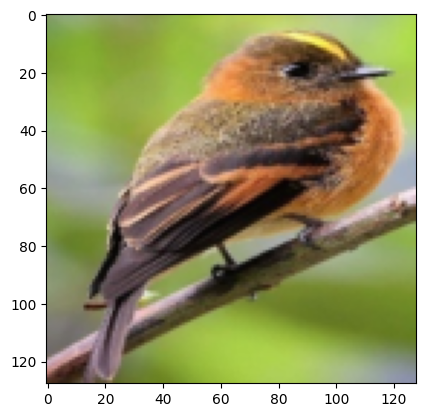

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

i = 0

for batch in val_loader:
  inputs, labels = batch["pixel_values"].to(device), batch["label"].to(device)
  for item in range(batch_size):
    image = batch["pixel_values"][item].to(device)
    output = model(image.reshape(1, 3, 128, 128))
    _, predicted = torch.max(output.data, 1)
    image = image.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(image)
    print("THE LABEL: ", bird_species[batch["label"][item].item() - 1])

    print("Prediction: ", bird_species[predicted.item() - 1])
    break
  break




# Load Model

In [ ]:
import os
print(os.getcwd())
model.load_state_dict(torch.load("/content/resnet_V4.pth", map_location=torch.device("cuda")))

/content


<All keys matched successfully>

# Training Loop and Eval

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
from functools import total_ordering
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, cooldown=1, min_lr=3e-8, eps=1e-09)

num_epochs = 15
print(f"Training for {num_epochs} epochs...")

best_val_accuracy = 0
epochs_no_improve = 0
early_stop_threshold = 3

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for i, batch in enumerate(train_loader):
        inputs, labels = batch["pixel_values"], batch["label"]
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels.to(device)).sum().item()
        total += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    val_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata["pixel_values"], vdata["label"]
            voutputs = model(vinputs.to(device))
            vloss = loss_fn(voutputs, vlabels.to(device))
            val_loss += vloss.item()
            _, predicted = torch.max(voutputs, 1)
            correct += (predicted == vlabels.to(device)).sum().item()
            total += vlabels.size(0)

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    val_losses.append(val_loss / len(val_loader))
    val_loss_epoch = val_loss/len(val_loader)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stop_threshold:
        print("Early stopping triggered. Validation accuracy did not improve for 10 consecutive epochs.")
        break

    scheduler.step(val_loss_epoch)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")


Training for 15 epochs...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/15, Train Loss: 0.40924369279851536, Validation Loss: 0.3136875462845944, Train Accuracy: 0.9144443788030956, Validation Accuracy: 0.9276190476190476
Epoch 2/15, Train Loss: 0.3656005959655026, Validation Loss: 0.2883374958512295, Train Accuracy: 0.9232350682341821, Validation Accuracy: 0.9333333333333333
Epoch 3/15, Train Loss: 0.3300143075476635, Validation Loss: 0.278131950276354, Train Accuracy: 0.9313877237549477, Validation Accuracy: 0.9337142857142857
Epoch 4/15, Train Loss: 0.29434081937955775, Validation Loss: 0.26694175004903004, Train Accuracy: 0.9392449932061204, Validation Accuracy: 0.9356190476190476
Epoch 5/15, Train Loss: 0.26545093847836576, Validation Loss: 0.254930483872991, Train Accuracy: 0.9461215809062444, Validation Accuracy: 0.9371428571428572
Epoch 6/15, Train Loss: 0.23985692707290046, Validation Loss: 0.2540990460708917, Train Accuracy: 0.9523955810243989, Validation Accuracy: 0.9371428571428572
Epoch 7/15, Train Loss: 0.2145866629377092, Validation 

In [ ]:
save_path = "/content/drive/MyDrive/resnet_V5.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch["pixel_values"].to(device), batch["label"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy}")

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

correct = {}
totals = {}

for batch in val_loader:
    inputs, labels = batch["pixel_values"].to(device), batch["label"].to(device)
    for item in range(len(batch["pixel_values"])):
        image = inputs[item]
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)

        label = labels[item].item()

        if predicted == label:
            correct[label] = correct.get(label, 0) + 1
        totals[label] = totals.get(label, 0) + 1

for i in correct.keys():
    print(f"Label {i} accuracy: {correct[i] / totals[i]}")


In [ ]:
for i in sorted(correct.keys()):
  print(f"Label {i} accuracy: {correct[i]/totals[i]}")